In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [5]:
combined_data = pd.read_csv("/scratch.global/csci8523_group_7/combined_data_w_lakes.csv")
combined_data.head()

,Unnamed: 0,Time,SST_lat0_lon0,SST_lat0_lon1,SST_lat0_lon2,SST_lat1_lon0,SST_lat1_lon1,SST_lat1_lon2,SST_lat2_lon0,SST_lat2_lon1,SST_lat2_lon2,Lat,Lon,lake_depth,ice_cover,water_level,Lake
0,10532,1995-01-01 12:00:00,4.047857,3.326,NaN,3.3360,3.100000,3.013906,5.118300,5.0210,4.1199,41.46,-81.85,NaN,NaN,NaN,e
1,10533,1995-01-02 12:00:00,4.001786,3.278,NaN,3.2884,3.051123,2.967031,5.070601,4.9723,4.0717,41.46,-81.85,NaN,NaN,NaN,e
2,10534,1995-01-03 12:00:00,3.947857,3.226,NaN,3.2366,3.001122,2.917031,5.018700,4.9215,4.0200,41.46,-81.85,NaN,NaN,NaN,e
3,10535,1995-01-04 12:00:00,3.885714,3.162,NaN,3.1707,2.933470,2.847812,4.952700,4.8571,3.9542,41.46,-81.85,NaN,NaN,NaN,e
4,10536,1995-01-05 12:00:00,3.815714,3.092,NaN,3.0999,2.862959,2.777344,4.881600,4.7844,3.8817,41.46,-81.85,NaN,NaN,NaN,e


In [6]:
combined_data.drop(['lake_depth', 'ice_cover', 'water_level'], axis=1, inplace=True)
combined_data['Time'] = pd.to_datetime(combined_data['Time'])
combined_data.head()

,Unnamed: 0,Time,SST_lat0_lon0,SST_lat0_lon1,SST_lat0_lon2,SST_lat1_lon0,SST_lat1_lon1,SST_lat1_lon2,SST_lat2_lon0,SST_lat2_lon1,SST_lat2_lon2,Lat,Lon,Lake
0,10532,1995-01-01 12:00:00,4.047857,3.326,NaN,3.3360,3.100000,3.013906,5.118300,5.0210,4.1199,41.46,-81.85,e
1,10533,1995-01-02 12:00:00,4.001786,3.278,NaN,3.2884,3.051123,2.967031,5.070601,4.9723,4.0717,41.46,-81.85,e
2,10534,1995-01-03 12:00:00,3.947857,3.226,NaN,3.2366,3.001122,2.917031,5.018700,4.9215,4.0200,41.46,-81.85,e
3,10535,1995-01-04 12:00:00,3.885714,3.162,NaN,3.1707,2.933470,2.847812,4.952700,4.8571,3.9542,41.46,-81.85,e
4,10536,1995-01-05 12:00:00,3.815714,3.092,NaN,3.0999,2.862959,2.777344,4.881600,4.7844,3.8817,41.46,-81.85,e


In [7]:
unique_years = sorted(combined_data["Time"].dt.year.unique())
unique_years[0]

def random_forecast_subset(data, context_years, forecast_length, max_attempts=1000):
    
    attempt = 0

    while attempt < max_attempts:
        
        random_start = np.random.randint(0, len(data) - forecast_length)
        forecast_subset = data.iloc[random_start:random_start + forecast_length]
        
        first_forecast_year = forecast_subset.iloc[0]["Time"].year
        if first_forecast_year >= (unique_years[0]+context_years):
            return forecast_subset
        
        attempt += 1

    raise ValueError(f"Condition not met within {max_attempts} attempts.")

In [8]:
def random_climatology_method(data, context_years=3, forecast_length=96):
    
    data['Time'] = pd.to_datetime(data['Time'])
    unique_coords = data[['Lat', 'Lon']].drop_duplicates()
    
    # Randomly select forecast_length consecutive days
    forecast_subset = random_forecast_subset(data, context_years, forecast_length)
    
    avg_SST_data = []
    test_SST_data = []
    
    for lat, long in unique_coords.values:
        
        lat_long_df = data[(data['Lat'] == lat) & (data['Lon'] == long)]
        
        for forecast_date in forecast_subset['Time']:
            
            context_dates = [forecast_date - pd.DateOffset(years=year_offset) for year_offset in range(1, context_years + 1)]
            context_data = lat_long_df[lat_long_df['Time'].isin(context_dates)]
            
            if not context_data.empty:
                avg_sst = context_data.iloc[:, 2:11].mean(skipna=True)
            else:
                avg_sst = [np.nan] * 9 
                
            avg_of_avg_SST = avg_sst.mean()
            
            avg_row = [forecast_date, *avg_sst.values, avg_of_avg_SST, lat, long]
            avg_SST_data.append(avg_row)
            
            test_sst = lat_long_df[lat_long_df['Time'] == forecast_date].iloc[:, 2:11].values[0]
            
            avg_of_test_SST = np.nanmean(test_sst)
            
            test_row = [forecast_date, *test_sst, avg_of_test_SST, lat, long]
            test_SST_data.append(test_row)
    
    avg_SST_df = pd.DataFrame(avg_SST_data, columns=['date', 'SST_lat0_lon0', 'SST_lat0_lon1', 'SST_lat0_lon2',
                                         'SST_lat1_lon0', 'SST_lat1_lon1', 'SST_lat1_lon2',
                                         'SST_lat2_lon0', 'SST_lat2_lon1', 'SST_lat2_lon2', 'total_average','Lat', 'Lon'])
    test_SST_df = pd.DataFrame(test_SST_data, columns=['date', 'SST_lat0_lon0', 'SST_lat0_lon1', 'SST_lat0_lon2',
                                         'SST_lat1_lon0', 'SST_lat1_lon1', 'SST_lat1_lon2',
                                         'SST_lat2_lon0', 'SST_lat2_lon1', 'SST_lat2_lon2', 'total_average', 'Lat', 'Lon'])
    
    return avg_SST_df, test_SST_df
    
    

In [21]:
np.random.seed(123)
avg_SST_df, test_SST_df = random_climatology_method(combined_data, 3, 96)

In [22]:
# Total MSE

mse_results = {}
for column in test_SST_df.columns[1:11]:
    col1 = test_SST_df[column]
    col2 = avg_SST_df[column]
    valid_mask = col1.notna() & col2.notna()
    mse = mean_squared_error(col1[valid_mask], col2[valid_mask])
    mse_results[column] = mse

# Print the results
print("Mean Squared Error for each coordinate:")
for col, mse in mse_results.items():
    print(f"{col}: {mse}")
print("Average sub MSE: ", (sum(mse_results.values()) / len(mse_results)))

Root Mean Squared Error for each coordinate:
SST_lat0_lon0: 1.0009484345822062
SST_lat0_lon1: 1.0380106146564076
SST_lat0_lon2: 1.047507846080455
SST_lat1_lon0: 1.0597011126551856
SST_lat1_lon1: 1.0140948225557518
SST_lat1_lon2: 1.027830350321453
SST_lat2_lon0: 0.9867312507975993
SST_lat2_lon1: 1.0410526963554
SST_lat2_lon2: 0.9845007188614657
total_average: 0.9301770078113412
Average sub RMSE:  1.0130554854677265


In [24]:
# MSE by Coordinate

unique_coords = test_SST_df[['Lat', 'Lon']].drop_duplicates()
sub_mse_results = []

for lat, long in unique_coords.values:
    
    test_SST = test_SST_df[(test_SST_df['Lat'] == lat) & (test_SST_df['Lon'] == long)]
    avg_SST = avg_SST_df[(avg_SST_df['Lat'] == lat) & (avg_SST_df['Lon'] == long)]
    
    average_mse = 0
    denom = 0
    for column in test_SST.columns[1:10]:
        col1 = test_SST[column]
        col2 = avg_SST[column]
        valid_mask = col1.notna() & col2.notna()
        
        if col1[valid_mask].empty:
            mse = 0
        else:
            mse = mean_squared_error(col1[valid_mask], col2[valid_mask])
            denom += 1
            
        average_mse += mse
        
    average_mse = average_mse / denom
        
    mse_row = [long, lat, average_mse]
    sub_mse_results.append(mse_row)

sub_mse_results_df = pd.DataFrame(sub_mse_results, columns=['Longitude', 'Latitude', 'Loss'])
sub_mse_results_df.head()

,Longitude,Latitude,Loss
0,-81.85,41.46,1.265825
1,-82.27,41.46,1.260908
2,-82.69,41.46,1.587855
3,-83.11,41.46,2.116042
4,-81.00,41.88,1.025145


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
def plot_loss_map(df, title):
    """
    Plots a map with colored squares representing loss values for given latitudes and longitudes.

    Parameters:
        df (pd.DataFrame): DataFrame with columns 'Longitude', 'Latitude', and 'Loss'.
    """
    # Define the square size for each point
    square_size = 0.35

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Normalize the loss values for color mapping
    norm = Normalize(vmin=df["Loss"].min(), vmax=df["Loss"].max())

    # Create a dense map by drawing squares
    for _, row in df.iterrows():
        rectangle = patches.Rectangle(
            (row["Longitude"], row["Latitude"]),
            square_size,
            -square_size,
            color=plt.cm.viridis(norm(row["Loss"])),
            linewidth=2
        )
        ax.add_patch(rectangle)

    # Add colorbar explicitly linked to the ScalarMappable
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label="Mean Squared Error Loss")

    # Set axis limits to match data range
    ax.set_xlim((-93, -75))  # Example longitude range
    ax.set_ylim((40, 50))    # Example latitude range

    # Plot settings
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(title)
    ax.grid(True)

    # Show the plot
    plt.show()

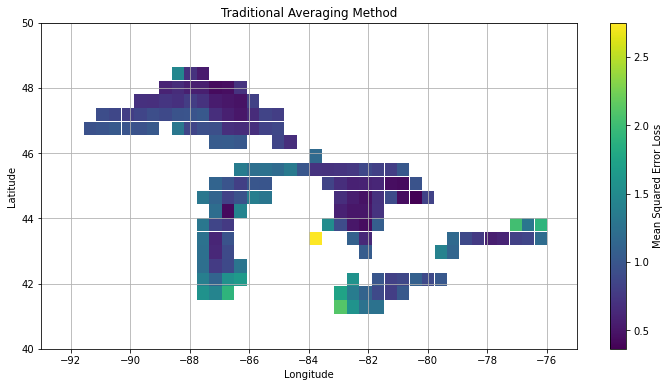

In [25]:
plot_loss_map(sub_mse_results_df, "Climatology Method")

# Climatology Method Given a Range of Dates

In [9]:
def given_climatology_method(data, context_years=3, forecast_length=96, start_date="0"):
    
    data['Time'] = pd.to_datetime(data['Time'])
    unique_coords = data[['Lat', 'Lon']].drop_duplicates()
    
    start_date = pd.to_datetime(start_date)
    
    forecast_subset = data[(data["Time"] >= start_date) & (data["Time"] < start_date + pd.Timedelta(days=forecast_length))]
    
    avg_SST_data = []
    test_SST_data = []
    
    for lat, long in unique_coords.values:
        
        lat_long_df = data[(data['Lat'] == lat) & (data['Lon'] == long)]
        
        for forecast_date in forecast_subset['Time'].drop_duplicates():
            
            context_dates = [forecast_date - pd.DateOffset(years=year_offset) for year_offset in range(1, context_years + 1)]
            context_data = lat_long_df[lat_long_df['Time'].isin(context_dates)]
            
            if not context_data.empty:
                avg_sst = context_data.iloc[:, 2:11].mean(skipna=True)
            else:
                avg_sst = [np.nan] * 9 
                
            avg_of_avg_SST = avg_sst.mean()
            
            avg_row = [forecast_date, *avg_sst.values, avg_of_avg_SST, lat, long]
            avg_SST_data.append(avg_row)
            
            test_sst = lat_long_df[lat_long_df['Time'] == forecast_date].iloc[:, 2:11].values[0]
            
            avg_of_test_SST = np.nanmean(test_sst)
            
            test_row = [forecast_date, *test_sst, avg_of_test_SST, lat, long]
            test_SST_data.append(test_row)
    
    avg_SST_df = pd.DataFrame(avg_SST_data, columns=['date', 'SST_lat0_lon0', 'SST_lat0_lon1', 'SST_lat0_lon2',
                                         'SST_lat1_lon0', 'SST_lat1_lon1', 'SST_lat1_lon2',
                                         'SST_lat2_lon0', 'SST_lat2_lon1', 'SST_lat2_lon2', 'total_average','Lat', 'Lon'])
    test_SST_df = pd.DataFrame(test_SST_data, columns=['date', 'SST_lat0_lon0', 'SST_lat0_lon1', 'SST_lat0_lon2',
                                         'SST_lat1_lon0', 'SST_lat1_lon1', 'SST_lat1_lon2',
                                         'SST_lat2_lon0', 'SST_lat2_lon1', 'SST_lat2_lon2', 'total_average', 'Lat', 'Lon'])
    
    return avg_SST_df, test_SST_df
    

In [21]:
avg_SST_df, test_SST_df = given_climatology_method(combined_data, 3, 96, "2023-08-01 12:00:00")

In [22]:
# Total MSE

mse_results = {}
for column in test_SST_df.columns[1:11]:
    col1 = test_SST_df[column]
    col2 = avg_SST_df[column]
    valid_mask = col1.notna() & col2.notna()
    mse = mean_squared_error(col1[valid_mask], col2[valid_mask])
    mse_results[column] = mse

# Print the results
print("Mean Squared Error for each coordinate:")
for col, mse in mse_results.items():
    print(f"{col}: {mse}")
print("Average sub MSE: ", (sum(mse_results.values()) / len(mse_results)))

Mean Squared Error for each coordinate:
SST_lat0_lon0: 3.0037656991660437
SST_lat0_lon1: 3.016410411749912
SST_lat0_lon2: 3.024206051400579
SST_lat1_lon0: 3.162201780196872
SST_lat1_lon1: 3.1161642411717305
SST_lat1_lon2: 3.217599685553803
SST_lat2_lon0: 3.2366870974075876
SST_lat2_lon1: 3.395868820476339
SST_lat2_lon2: 3.3405313240432575
total_average: 2.914491526391609
Average sub MSE:  3.142792663755773


In [23]:
# MSE by Coordinate

unique_coords = test_SST_df[['Lat', 'Lon']].drop_duplicates()
sub_mse_results = []

for lat, long in unique_coords.values:
    
    test_SST = test_SST_df[(test_SST_df['Lat'] == lat) & (test_SST_df['Lon'] == long)]
    avg_SST = avg_SST_df[(avg_SST_df['Lat'] == lat) & (avg_SST_df['Lon'] == long)]
    
    average_mse = 0
    denom = 0
    for column in test_SST.columns[1:10]:
        col1 = test_SST[column]
        col2 = avg_SST[column]
        valid_mask = col1.notna() & col2.notna()
        
        if col1[valid_mask].empty:
            mse = 0
        else:
            mse = mean_squared_error(col1[valid_mask], col2[valid_mask])
            denom += 1
            
        average_mse += mse
        
    average_mse = average_mse / denom
        
    mse_row = [long, lat, average_mse]
    sub_mse_results.append(mse_row)

sub_mse_results_df = pd.DataFrame(sub_mse_results, columns=['Longitude', 'Latitude', 'Loss'])
sub_mse_results_df.head()

,Longitude,Latitude,Loss
0,-81.85,41.46,1.507480
1,-82.27,41.46,1.781720
2,-82.69,41.46,1.985144
3,-83.11,41.46,2.593547
4,-81.00,41.88,1.356134


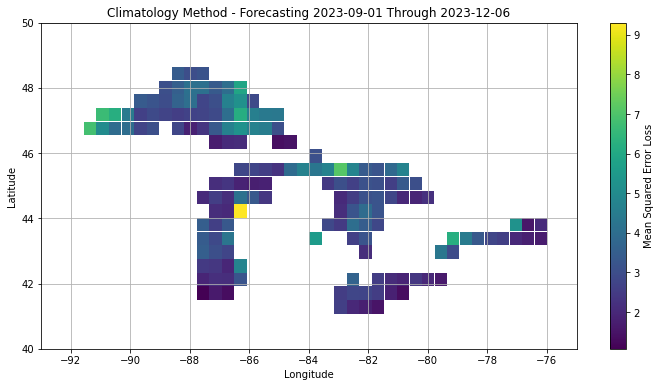

In [25]:
plot_loss_map(sub_mse_results_df, "Climatology Method - Forecasting 2023-09-01 Through 2023-12-06")